In [23]:
import json
import numpy as np
import requests
from tensorflow import keras

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt
import os
import subprocess


fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

data = json.dumps({"signature_name": "serving_default",
                  "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))





train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64
Data: {"instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0] ... 0.0], [0.0]]]], "signature_name": "serving_default"}


In [8]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


{
    "predictions": [[5.41536906e-07, 5.39583533e-09, 2.992806e-08, 5.48840218e-09, 8.33919245e-09, 0.00856120791, 1.21917753e-06, 0.0673106387, 0.00105269358, 0.92307353], [0.00552762765, 3.73170337e-07, 0.877711535, 7.26375365e-05, 0.0979741961, 8.30658459e-12, 0.0186234787, 8.70590221e-13, 9.01024468e-05, 9.0992984e-11], [1.10471119e-05, 0.999875069, 3.81516463e-09, 0.000102226935, 7.8197445e-06, 9.73717551e-10, 3.90097426e-07, 1.12905174e-09, 3.28217357e-06, 2.30088126e-09]
    ]
}


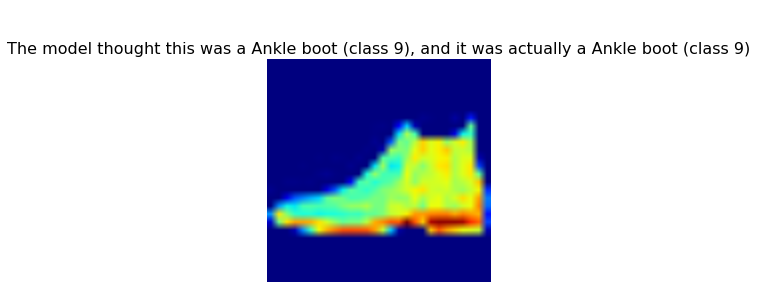

In [10]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion:predict', data=data, headers=headers)
print(json_response.text)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

[[5.41536906e-07, 5.39583533e-09, 2.992806e-08, 5.48840218e-09, 8.33919245e-09, 0.00856120791, 1.21917753e-06, 0.0673106387, 0.00105269358, 0.92307353], [0.00552762765, 3.73170337e-07, 0.877711535, 7.26375365e-05, 0.0979741961, 8.30658459e-12, 0.0186234787, 8.70590221e-13, 9.01024468e-05, 9.0992984e-11], [1.10471119e-05, 0.999875069, 3.81516463e-09, 0.000102226935, 7.8197445e-06, 9.73717551e-10, 3.90097426e-07, 1.12905174e-09, 3.28217357e-06, 2.30088126e-09]]


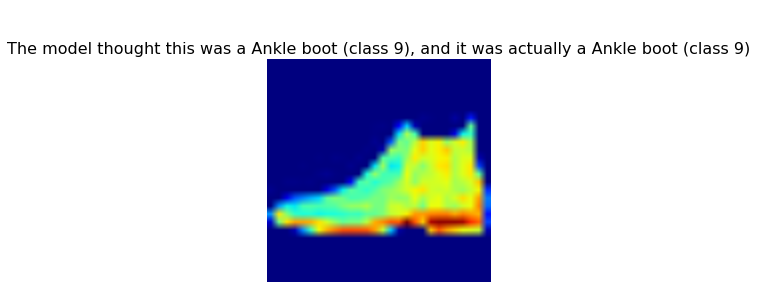

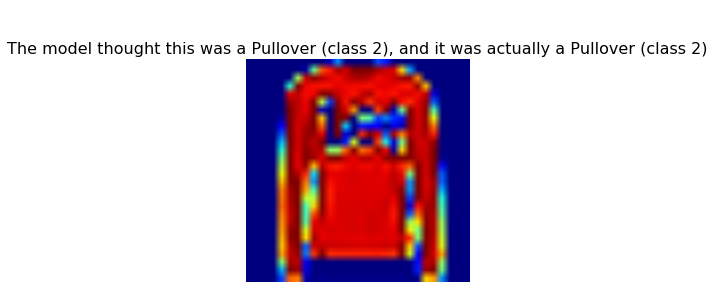

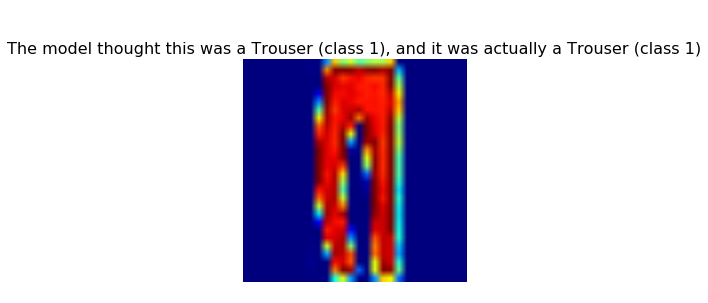

In [15]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

print(predictions)

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

In [39]:
def show_result(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


[[5.41536906e-07 5.39583533e-09 2.99280600e-08 5.48840218e-09
  8.33919245e-09 8.56120791e-03 1.21917753e-06 6.73106387e-02
  1.05269358e-03 9.23073530e-01]
 [5.52762765e-03 3.73170337e-07 8.77711535e-01 7.26375365e-05
  9.79741961e-02 8.30658459e-12 1.86234787e-02 8.70590221e-13
  9.01024468e-05 9.09929840e-11]
 [1.10471119e-05 9.99875069e-01 3.81516463e-09 1.02226935e-04
  7.81974450e-06 9.73717551e-10 3.90097426e-07 1.12905174e-09
  3.28217357e-06 2.30088126e-09]]


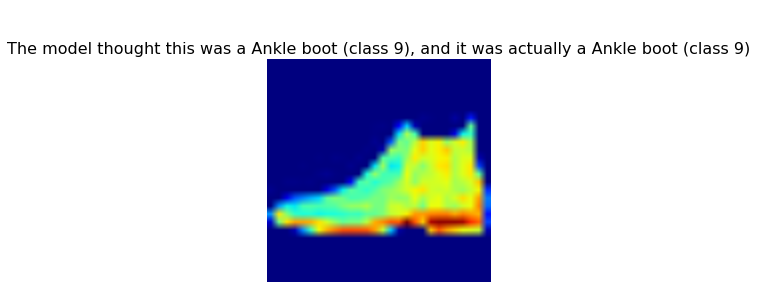

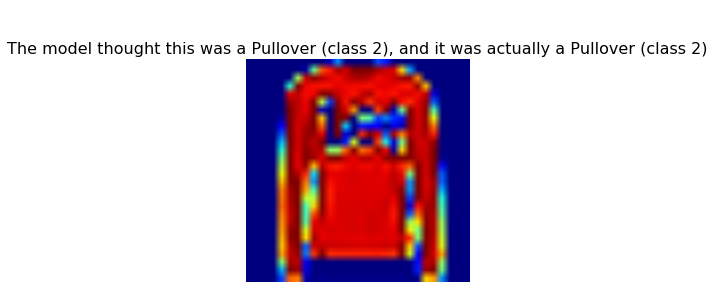

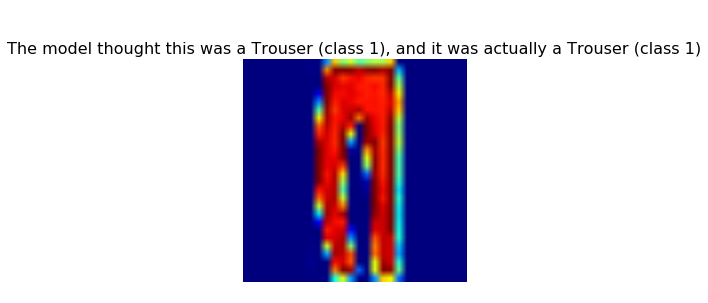

In [41]:
import time
import grpc
from tensorflow.contrib.util import make_tensor_proto

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc


def run(host, port, model, signature_name):

    channel = grpc.insecure_channel('{host}:{port}'.format(host=host, port=port))
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    
    start = time.time()

    # Call classification model to make prediction on the image
    request = predict_pb2.PredictRequest()
    request.model_spec.name = model
    request.model_spec.signature_name = signature_name
    request.inputs['Conv1_input'].CopyFrom(make_tensor_proto(test_images[:3], shape=[3, 28, 28, 1], dtype=tf.float32))
    
#     print(request)

    result = stub.Predict(request, 5.0)

    end = time.time()
    time_diff = end - start

    # Reference:
    # How to access nested values
    # https://stackoverflow.com/questions/44785847/how-to-retrieve-float-val-from-a-predictresponse-object
#     print(result)
    predictions = tf.make_ndarray(result.outputs["Softmax"])
    print(predictions)

    for i in range(0,3):
      show_result(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))
    

host = "localhost"
port = 8500
model = "fashion"
signature_name = "serving_default"
run(host, port, model, signature_name)